In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sqlite3
import seaborn as sns
import collections


sns.set(style='white', palette="Set2", color_codes=False)
sns.set_style("ticks")

%matplotlib inline

In [2]:
def get_dataframes(query, databases):
    dataframes = []
    for database in databases:
        db = sqlite3.connect(database)
        dataframes += [pd.read_sql_query(query, db)]
    return pd.concat(dataframes)

In [3]:
query = 'select * from tasks;'
databases = [             
             'data.db'
             ]
tasks = get_dataframes(query, databases)

In [4]:
query = 'select * from pods;'
databases = [             
             'data.db'
             ]
pods = get_dataframes(query, databases)

In [5]:
start = min(int(tasks['start_submit'].min()), int(pods['timestamp'].min()))
end = max(int(tasks['start_submit'].max()), int(pods['timestamp'].max()))
print(start, end)

1579586747 1579587128


In [6]:
tasks['start'] = tasks['start_submit'] - start
tasks['end'] = tasks['returned'] - start
pods['time'] = pods['timestamp'] - start
tasks.head()

,platform,start_submit,returned,num_workers,tasks_per_trial,task_type,failed,start,end
0,kube,1.579587e+09,1.579587e+09,64,20,sleep-1,0,0.266732,21.282672
1,kube,1.579587e+09,1.579587e+09,64,20,sleep-10,0,0.267638,30.534315
2,kube,1.579587e+09,1.579587e+09,64,20,sleep-10,0,0.267903,31.496880
3,kube,1.579587e+09,1.579587e+09,64,20,sleep-10,0,0.268145,33.967785
4,kube,1.579587e+09,1.579587e+09,64,20,sleep-10,0,0.268411,35.172220


Text(0.5, 0, 'Elapsed time (s)')

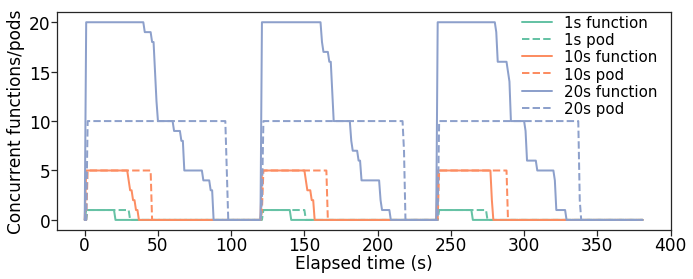

In [7]:
task_types = list(tasks['task_type'].unique())
pod_types = ['noop_0', 'noop_1', 'noop_10']
task_dist = {}
pod_dist = {}
for task_type in task_types:
    df1 = tasks[tasks['task_type'] == task_type]
    task_dist[task_type] = [0] * (end - start + 1)
    pod_dist[task_type] = [0] * (end - start + 1)
    for i, row in df1.iterrows():
        for j in range(int(row['start']) + 1, int(row['end'])):
            task_dist[task_type][j] += 1

for i, row in pods.iterrows():
    last = 0
    for j in range(len(pod_types)):
        pod_dist[task_types[j]][int(row['time'])] = row[pod_types[j]]
        
fig, ax = plt.subplots(figsize=(11,4))
for i, type in enumerate(task_types):
    plt.plot(list(range(end - start + 1)), 
             task_dist[type], 
             label='{}s function'.format(type.strip('sleep-')),
             c=sns.color_palette()[i],
             linewidth=2)
    plt.plot(list(range(end - start + 1)), 
             pod_dist[type], 
             label='{}s pod'.format(type.strip('sleep-')), 
             c=sns.color_palette()[i],
             linewidth=2,
             linestyle='--')
legend = plt.legend(loc='upper right', 
                    ncol=1, 
                    bbox_to_anchor=(1, 1.05), 
                    columnspacing=-0.2,
                    labelspacing=0.15,
                    fancybox=True, frameon=True, fontsize=15, framealpha=0)
plt.setp(legend.get_texts(), color='black')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)
#ax.set_xlim(0, 450)
ax.tick_params(axis='y', which='minor')
ax.tick_params(axis='both', which='major', pad=0, labelsize=17, labelcolor='black')
ax.set_ylabel('Concurrent functions/pods', fontsize=17, color='black')
ax.set_xlabel('Elapsed time (s)', labelpad=0, fontsize=17, color='black')
#plt.savefig('elasticity.png', 
#            bbox_inches = "tight", 
#            dpi=1000)


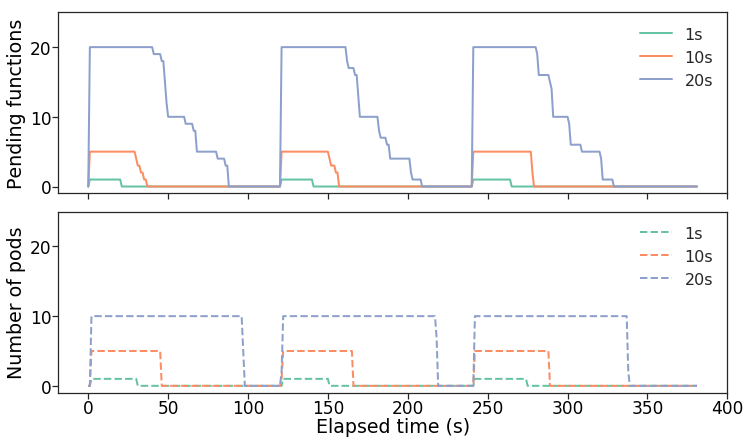

In [8]:
task_types = list(tasks['task_type'].unique())
pod_types = ['noop_0', 'noop_1', 'noop_10']
task_dist = {}
pod_dist = {}
for task_type in task_types:
    df1 = tasks[tasks['task_type'] == task_type]
    task_dist[task_type] = [0] * (end - start + 1)
    pod_dist[task_type] = [0] * (end - start + 1)
    for i, row in df1.iterrows():
        for j in range(int(row['start']) + 1, int(row['end'])):
            task_dist[task_type][j] += 1

for i, row in pods.iterrows():
    last = 0
    for j in range(len(pod_types)):
        pod_dist[task_types[j]][int(row['time'])] = row[pod_types[j]]
        
fig, axes = plt.subplots(2, 1, figsize=(12,7), sharex=True)
ax2, ax1 = axes[0], axes[1]
for i, type in enumerate(task_types):
    ax2.plot(list(range(end - start + 1)), 
             task_dist[type], 
             label='{}s'.format(type.strip('sleep-')),
             c=sns.color_palette()[i],
             linewidth=2)
    ax1.plot(list(range(end - start + 1)), 
             pod_dist[type], 
             label='{}s'.format(type.strip('sleep-')),
             c=sns.color_palette()[i],
             linewidth=2,
             linestyle='--')
ax1.legend(fancybox=True, frameon=True, fontsize=16, framealpha=0)
ax2.legend(fancybox=True, frameon=True, fontsize=16, framealpha=0)
plt.setp(legend.get_texts(), color='black')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)
ax2.set_ylim(-1, 25)
ax1.set_ylim(-1, 25)
ax1.tick_params(axis='y', which='minor')
ax1.tick_params(axis='both', which='major', pad=0, labelsize=17, labelcolor='black')
ax2.tick_params(axis='y', which='minor')
ax2.tick_params(axis='both', which='major', pad=0, labelsize=17, labelcolor='black')
ax2.set_ylabel('Pending functions', fontsize=19, color='black')
ax1.set_ylabel('Number of pods', fontsize=19, color='black')
ax1.set_xlabel('Elapsed time (s)', labelpad=0, fontsize=19, color='black')
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('elasticity.pdf', 
            bbox_inches = "tight", 
            dpi=1000)